# Building a CNN using Keras (TensorFlow as backend)

## Access the Data

We need to gain access to our training and validation data that we will be using to build our model first.

The data is in the same Github repo, but since our Colab notebook doesn't have access to this, 
we need to clone the repo again (yes, this is a bit of a backwards process. An alternative is to upload the data manually from Google Drive or our local machinges, but this is the fastest for now).

In [2]:
# remove if older version exists
!rm -rf learn_image_classification_2
!git clone https://github.com/SchoolofAI-Vancouver/learn_image_classification_2.git

Cloning into 'learn_image_classification_2'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 258 (delta 31), reused 225 (delta 16), pack-reused 0
Receiving objects: 100% (258/258), 3.92 MiB | 3.17 MiB/s, done.
Resolving deltas: 100% (31/31), done.


Let's see if the repo is visible to our Google Colab environment.

In [1]:
# see the content of the currend directory (cd)
!ls

learn_image_classification_2  sample_data


Now let's change the current directory to the repo root.

**Sidenotes**

* The `%` is necessary to specify that it's this notebook's current directory (`cd`) you want to change. 
* The `!` is how you specify a shell command (command running in your terminal, opposed to Python command)

In [4]:
# change current direcory to the root folder of the repo
%cd learn_image_classification_2/
# verify that we are in the repo
!ls

/content/learn_image_classification_2
additional  data  keras_colab_demo  LICENSE  README.md	src


The `data` folder is what we will be using for our model. We are again building a cat/dog classifier.



## Build the Model

This tutorial was adapted from the [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) post. Follow the link if you are interested in some of the detail not covered here.

## Change Notebook Settings

A very good motivation for using Google Colab is it allows you to use a free GPU when running code that can be processed by a GPU. The 2D images input makes CNNs the perfect candidate for training the model using a GPU. At a later stage compare the model training duration on a GPU vs a CPU to see the benefits for yourself.

Go to `Edit -> Notebook Settings` and alter as needed:

*  **Runtime Type: Python 3**
* **Hardware Accelerator: GPU**

### Load Dependencies

Let's import the package dependencies first.

In [5]:
# data augmenting / preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# model architecture and training
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# GPU check
from tensorflow.python.client import device_lib

# displaying images in notebook
from IPython.display import Image, display

# finding files
import os

# array stuff
import numpy as np

Using TensorFlow backend.


### Check that you have GPU access (not required, but beneficial)

In [6]:
# Go to Edit -> Notebook Settings to enable a GPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11762757746877113334
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281989632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11847074927807015866
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### Data Augmentation Example

* Augmenting input images by making small changes, increases the number, and diversity, of input images. This will increase the model's probability of learning the correct image features

* Below follows a visual example of how images can be augmented. Keras will take care of this during training (we aren't going to use these example images during training).

In [0]:
# create temporary directory to store the the example augmented images
!mkdir data/transform_samples

In [8]:
# augmentation specs
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# original image
img = load_img('data/train/cat/cat.9.jpg')

# convert image to Numpy array (numeric value representation of image)
x = img_to_array(img)
print("Image Shape: {}".format(x.shape))

# reshape for Keras use
x = x.reshape((1,) + x.shape)
print("Image Shape: {}".format(x.shape))


# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `data/transform_samples/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data/transform_samples', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 3:
        break  # otherwise the generator would loop indefinitely

Image Shape: (425, 320, 3)
Image Shape: (1, 425, 320, 3)


Let's see if our new, augmented images exist.

In [9]:
!ls data/transform_samples/

cat_0_6467.jpeg  cat_0_6556.jpeg  cat_0_72.jpeg  cat_0_93.jpeg


**Original Image**

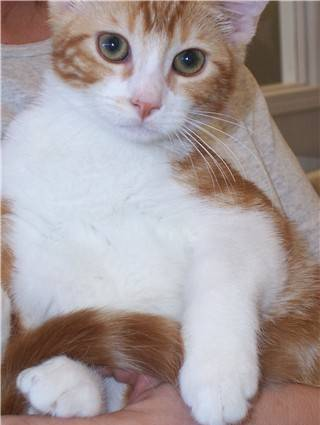

In [10]:
Image('data/train/cat/cat.9.jpg')

**Augmented Images**

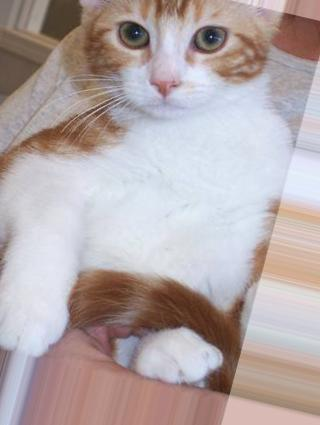

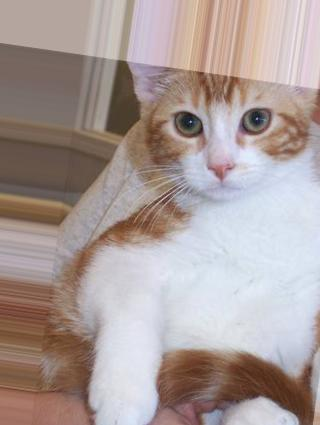

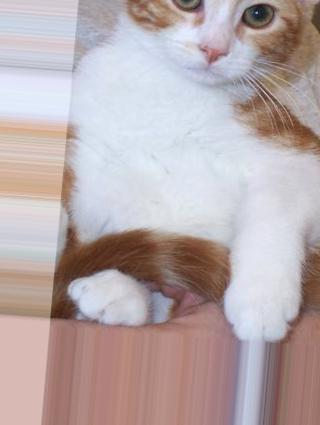

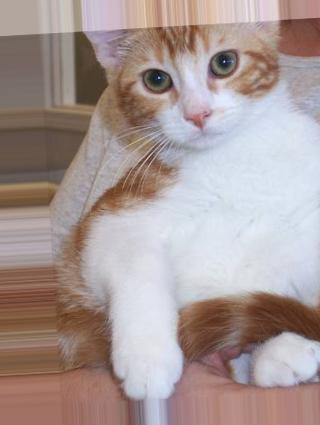

In [11]:
for file in os.listdir("data/transform_samples"):
    display(Image(os.path.join("data/transform_samples", file)))

**Remove Example Images (just because)**

In [0]:
!rm -rf data/transform_samples

### Model Architecture

In [0]:
# fully connected model (opposed to model with different input / branches)
model = Sequential()

# input and first hidden layer
# - 2D images (Conv2D - https://keras.io/layers/convolutional/#conv2d)
# - 32 filters applied to input images (meaning 32 outputs per image)
# - filter/kernel has size (3x3)
# - strides is by default (1,1), meaning the filter moves one pixel at a time (both directions)
# - padding is by default 'valid', meaning if the image doesn't meet input shape, padding will be added
model.add(Conv2D(32, (3, 3), input_shape=(164, 164, 3)))
# activation function (ensures non-linearity)
model.add(Activation('relu'))
# max pooling reduces dimensionality
model.add(MaxPooling2D(pool_size=(2, 2)))

# second hidden layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third hidden layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)
# now we need to flatten it to allow computation
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# a normal 1D hidden layer with less neurons (not necessary)
model.add(Dense(64))
model.add(Activation('relu'))

# dropout removes influence of neurons that don't add value
model.add(Dropout(0.5))

# output layer (2 neurons) (bug with binary - now matching num of classes - https://github.com/keras-team/keras/issues/6499)
# this will give us our 'probability' value
model.add(Dense(2))

# change to a value between 0 and 1
model.add(Activation('softmax')) # binary bug (binary use 'sigmoid')

# model training configuration (https://keras.io/models/model/)
# loss function - binary crossentropy - ideal for 2 classes # bug - https://github.com/keras-team/keras/issues/6499
# optimizer - rmsprop (http://ruder.io/optimizing-gradient-descent/index.html#rmsprop) - for gradient descent (finding best weights)
# metrics - accuracy (proportion of correrctly classified images over number of total images)
model.compile(loss='categorical_crossentropy',
              optimizer='Adam', # rmsprop
              metrics=['accuracy'])

### Data Preparation / Augmentation

In [14]:
# number of images fed into CNN at a time
# not too big - will take forever to train
# not too small - model will struggle to get a good idea of 
# the classes in general
batch_size = 16

# augment settings for training data
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255, #RGB colours (change values to 0 to 1)
        shear_range=0.2, #tilt random images (20% of images)
        zoom_range=0.2, # zoom random iamges (20% of images)
        horizontal_flip=True) # flip images

# augment settings for validation data
# this is the augmentation configuration we will use for validation:
# only rescaling
validate_datagen = ImageDataGenerator(rescale=1./255) #RGB colours (change values to 0 to 1)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(164, 164),  # all images will be resized to 164x164 (same as input shape in architecture)
        batch_size=batch_size,
        class_mode='categorical')  # bug with binary - https://github.com/keras-team/keras/issues/6499- since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = validate_datagen.flow_from_directory(
        'data/validate',
        target_size=(164, 164),
        batch_size=batch_size,
        class_mode='categorical') # bug with 'binary' - https://github.com/keras-team/keras/issues/6499

Found 137 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


### Model Training

In [15]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size, # total number of images processed is batch_size*steps_per_epoch*epochs
        epochs=4,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

Epoch 1/4
125/125 [==============================] - 26s 206ms/step - loss: 0.6538 - acc: 0.6170 - val_loss: 0.6280 - val_acc: 0.6429
Epoch 2/4
125/125 [==============================] - 25s 203ms/step - loss: 0.4036 - acc: 0.8156 - val_loss: 0.6675 - val_acc: 0.7143
Epoch 3/4
125/125 [==============================] - 25s 202ms/step - loss: 0.2039 - acc: 0.9127 - val_loss: 1.0549 - val_acc: 0.7143
Epoch 4/4
125/125 [==============================] - 25s 198ms/step - loss: 0.1190 - acc: 0.9599 - val_loss: 0.5660 - val_acc: 0.7857


### Saving and Reusing or Retraining the Model

Check out [this tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) on how to save the model, load it again, use it for classifications or retraining (as we saw in the previous workshop).

### Classify on New Image

There's a stupid bug with keeping the order of files when trying to predict on multiple at the same time. Check out this [link](https://github.com/keras-team/keras/issues/3296) if you're interested.

So we will classify new cats and dogs seperately for now.

**Dogs**

In [49]:
batch_size = 1

test_generator = datagen.flow_from_directory(
        'data/test/dog', # never seen before images - IMPORTANT - still needs subfolder(s)
        target_size=(164, 164), # same as input shape
        batch_size=batch_size, # number of images going in at the same time
        class_mode='categorical',  # this means our generator will only yield batches of data, no labels
        shuffle=False)  # our data will be in order, 5 cats then 5 dogs

# bug fix workaround - https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2
predictions = model.predict_generator(test_generator)
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

print(predictions)

Found 5 images belonging to 1 classes.
['dog', 'dog', 'dog', 'dog', 'dog']


**Cats**

In [50]:
batch_size = 1

test_generator = datagen.flow_from_directory(
        'data/test/cat', # never seen before images - IMPORTANT - still needs subfolder(s)
        target_size=(164, 164), # same as input shape
        batch_size=batch_size, # number of images going in at the same time
        class_mode='categorical',  # this means our generator will only yield batches of data, no labels
        shuffle=False)  # our data will be in order, 5 cats then 5 dogs

# bug fix workaround - https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2

predictions = model.predict_generator(test_generator)
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

print(predictions)

Found 5 images belonging to 1 classes.
['dog', 'dog', 'cat', 'cat', 'cat']
